## PyCPT_s2sv1.3 --21 July 2019
## Produce S2S (un)calibrated forecasts and assess associated skill 


#### Authors: 
Authors: ÁG Muñoz (agmunoz@iri.columbia.edu), AW Robertson (awr@iri.columbia.edu), SJ Mason, T Turkington (NEA)

#### Acknowledgements: 
Rémi Cousin (IRI, key Ingrid code), James Doss-Gollin (Columbia Water Center, original download Python functions).
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson). 

#### Version log
* 21 July 2019, AGM: added functions to download noMOS netcdf probabilistic forecast files and plot them.
* 17 July 2019, AGM: noMOS now uses clim period that is consistent with the raw forecast; several related minor changes to different functions.
* 16 July 2019, TK: fixed bug in Obs_RFREQ and pltmapProb routines;
* 6 July 2019, AGM: added option for different thresholds in the flexible format figures
* 30 June 2019, AGM: added option to plot percentiles in flexible format
* 6 June 2019, AGM: fixed bug in PyIngrid related to the number of initializations used for the ECMWF model, and optimized reading multiple records in sequential Fortran binary (GrADS) files.
* 21 Apr 2019, AGM: added option to list average skill metrics for particular subdomains.
* 17 Apr 2019, AGM: fixed bug related to the inverse Gamma function.
* 30 Mar 2019, AGM: added PCR option, CHIRPS as obs, flexible format plots, automatically uses retrospective for validation (due to the very high sample size). Solved problems related to masking missing values. ELR still has some problems (values are different from our R or Matlab codes -- working on it, so not included in this version).
* 25 Aug 2018, AGM: added CPC Unified data as obs, plots are now raster maps, fixed field shift due to sequential grads format in CPT, automatic colobar limits and field name for deterministic forecast
* 24 Aug 2018, AWR: IMD data version (not public).
* 23 Aug 2018, AWR: GEFS SubX model added.
* 15 Aug 2018, AGM: Plotting capabilities added.
* PyCPTv1.1:ECMWF/CFSv2-TRMM, modified by AGM on 1 Aug 2018
* Previous version: 17 Jul 2018, modified by AWR
* First iPython version (Jupyter Notebook) by AWR -- 24 Jun 2018
* First version (BASH) by AGM -- 12 Dec 2017 

#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7), CHIRPS, CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* Probabilistic forecasts, in terciles and flex format.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is not deleted anymore at the beginning of the process, but scripts are!
2. Initializations available per month are used, concatenated.
3. The T coordinate has been faked, so CPT can deal with all the initializations.

### Namelist section

In [1]:
########Work name (name of the case/experiment, try one word)
work='KenyaOND'
#work='ASEAN3_OND' # ASEAN default

########Model (choose between ECMWF, CFSv2, GEFS)
model='ECMWF'

########Obs (choose between CHIRPS, TRMM, CPC, IMD1deg, IMDp25deg)
obs='CHIRPS'

########MOS method (choose between None, PCR, CCA and ELR)
MOS='None'

########Forecast date  
##-- If ECMWF, it needs to be a Monday or a Thursday! CFSv2: any day; GEFS: Wednesdays.
#mon='May' 	# Forecast month ASEAN default
mon='Nov' 	# Forecast month Kenya
#fyr=2019 	# Forecast year ASEAN default
fyr=2018 	# Forecast year Kenya
#fday=6 	# Forecast day  May 6, ASEAN default
fday=5 	# Forecast day  [Nov 5, 2018, Monday]
#training_season='Apr-Jun' # ASEAN default
training_season='Oct-Dec' # Kenya
#training_season='Nov' #for CFSv2 and GEFS, use 3 months with the initialization as the middle one

nwk=4 # Number of weeks to process (leads)

########Switches:
force_download = True   #force download of data files, even if they already exist locally
# Rainfall frequency switch 
rainfall_frequency = False  #False gives total rainfall for forecast period

wetday_threshold = 3 #WET day threshold (mm) --only used if rainfall_frequency is True!
threshold_pctle = False    #False for threshold in mm; Note that if True then if counts DRY days!!!

# Kenya: 34E-43E, 5S-6N
########Spatial domain for predictor
nla1=10 	# Northernmost latitude
sla1=-10 	# Southernmost latitude
wlo1=30 	# Westernmost longitude
elo1=50 	# Easternmost longitude
# Spatial domain for predictand
nla2=6 	# Northernmost latitude
sla2=-5 	# Southernmost latitude
wlo2=34 	# Westernmost longitude
elo2=43 	# Easternmost longitude

# ASEAN Default
########Spatial domain for predictor
# nla1=30 	# Northernmost latitude
# sla1=-20 	# Southernmost latitude
# wlo1=73 	# Westernmost longitude
# elo1=155 	# Easternmost longitude
# #Spatial domain for predictand
# nla2=24 	# Northernmost latitude
# sla2=-12 	# Southernmost latitude
# wlo2=90 	# Westernmost longitude
# elo2=150 	# Easternmost longitude

########Forecast lead interval
# Lists for looping over lead times
wk = [1,2,3,4,34]  # week-lead number label (week1, week2, week3-4)
# ECMWF - first day is day 0, 0000Z accumulated rainfall; specify day1=0 for week 1
# GEFS - first day is day 0.5 (daily average rainfall rate); specify day1=0 for week 1
# CFSv2 - first day is day 1, 0000Z accumulated rainfall over the first day; specify day1=1 for week 1 
day1 = [0,7,14,21,14]  # first lead day of target weeks 
#day1 = [0,7,14,14,14]  # first lead day of target weeks 
day2 = [7,14,21,28,28]  # last lead day of target weeks 
# 
wknam= ['Week 1','Week 2','Week 3','Week 4','Week 3-4']  #naming the weeks (for plots)
#wknam= ['Week 1','Week 2','Week 3','Week 3-4','Week 3-4']  #naming the weeks (for plots)

In [3]:
########Some folder and file options:
# Working directory --it should exist!!!
workdir = '/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/'
#workdir = '/Users/andy/Desktop/PyCPTtest/'
#workdir = '/Users/andy/Dropbox/Cabinet/Meetings/2019/ICPAC-Nov2019/PyCPT/PyCPTtest/'

# PATH to CPT root directory
cptdir='/Users/agmunoz/Documents/Angel/CPT/CPT/15.7.8/'
#cptdir='/Users/andy/Dropbox/pgm/stats/CPT/CPT15/15.7.8/'

########Naming of output files
if rainfall_frequency:
    fprefix = 'RFREQ'
else:
    fprefix = 'PRCP'

########Model-dependent parameters
if model=='CFSv2':
    hstep = 3 # use all starts in the trainng period with this daily step between them (v5 used 7)
    nlag  = 3  # length of the lagged ensemble in days
    ntrain= 363 # Length of training period
elif model=='ECMWF':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 160  # Length of training period
elif model=='GEFS':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 219  # Length of training period (for JJA, 1999-2015)   
else:
    print ("Model option is invalid")
    
########Observation dataset URLs
if obs == 'TRMM':
    obs_source = 'SOURCES/.NASA/.GES-DAAC/.TRMM_L3/.TRMM_3B42/.v7/.daily/.precipitation/X/0./1.5/360./GRID/Y/-50/1.5/50/GRID'
    hdate_last = 2014
elif obs == 'CPC':
    obs_source = 'SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/X/0./.5/360./GRID/Y/-90/.5/90/GRID'
    hdate_last = 2018
elif obs == 'CHIRPS':
    obs_source = 'SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/X/0./.5/360./GRID/Y/-90/.5/90/GRID'
    hdate_last = 2018
elif obs == 'IMD1deg':
    obs_source = 'SOURCES/.IMD/.NCC1-2005/.v4p0/.rf'
    hdate_last = 2015
elif obs == 'IMDp25deg':
    obs_source = 'SOURCES/.IMD/.RF0p25/.gridded/.daily/.v1901-2015/.rf'
    hdate_last = 2016
else:
    print ("Obs option is invalid")
    
########MOS-dependent parameters
if MOS=='None':
    mpref='noMOS'
elif MOS=='CCA':
    mpref='CCA'
elif MOS=='PCR':
    mpref='PCR'
elif MOS=='ELR':
    mpref='ELRho'
#else:
#    print ("MOS option is invalid")

# S2S Database key
print("PyCPT folder is:")
%cd $workdir
!mkdir -p $work
with open(workdir+'.IRIDLAUTH') as file:
    authkey = file.read() 

PyCPT folder is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT


### End of namelist section  (do not modify anything below this line)

#### Load Libraries

In [4]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
print("Python libraries loaded")
print("Now in the work directory:")
%cd $work
workdir = os.getcwd()

Python libraries loaded
Now in the work directory:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/KenyaOND


In [5]:
if rainfall_frequency:
    print('Predictand is Rainfall Frequency; wet day threshold = '+str(wetday_threshold)+' mm')
else:
    print('Predictand is Rainfall Total (mm)')

print("")
print("Creating input, output and script folders, if not already there...")
#print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p input/noMOS
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*

# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("")
print("CPT environment loaded. Using this CPT version:")
print(cptdir)

Predictand is Rainfall Total (mm)

Creating input, output and script folders, if not already there...
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/KenyaOND

CPT environment loaded. Using this CPT version:
/Users/agmunoz/Documents/Angel/CPT/CPT/15.7.8/


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

Forecast date is 5 Nov 2018

   November 2018
Mo Tu We Th Fr Sa Su
          1  2  3  4
 5  6  7  8  9 10 11
12 13 14 15 16 17 18
19 20 21 22 23 24 25
26 27 28 29 30

   December 2018
Mo Tu We Th Fr Sa Su
                1  2
 3  4  5  6  7  8  9
10 11 12 13 14 15 16
17 18 19 20 21 22 23
24 25 26 27 28 29 30
31



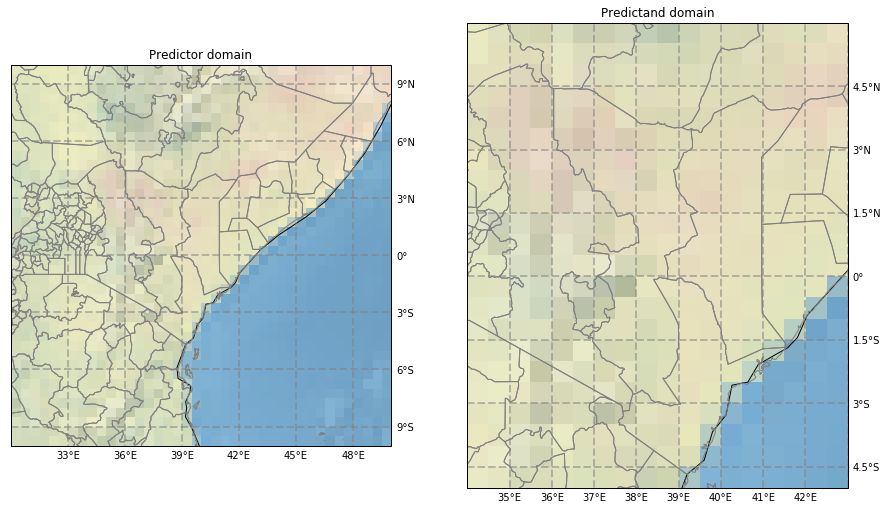

In [6]:
#Print calendars
print('Forecast date is '+str(fday)+' '+mon+' '+str(fyr))
print('')
c=calendar.TextCalendar(calendar.MONDAY)
print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)))
if list(calendar.month_abbr).index(mon)+1==13:
    print(c.formatmonth(fyr+1,1))
else:
    print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)+1))

#Plot domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2)

In [7]:
# Diagnostics
print(range(nwk))
for L in range(nwk):
    print(L,day1[L], day2[L], wk[L])

range(0, 4)
0 0 7 1
1 7 14 2
2 14 21 3
3 21 28 4


# Download data if necessary, and run CPT

In [8]:
for L in range(nwk):
   nday=day2[L]-day1[L]	# Length of target period (days) 
   print("New folder:")
   %cd $workdir/input

   PrepFiles(rainfall_frequency,threshold_pctle, wlo1, wlo2,elo1, elo2,sla1, sla2,nla1, nla2, day1[L], day2[L], fday, nday, fyr, mon, os, authkey, wk[L], wetday_threshold, nlag, training_season, hstep, model, obs_source, hdate_last, force_download)
 
   print("New folder:")
   %cd $workdir/scripts

   CPTscript(mon,fday,wk[L],nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,training_season,ntrain,rainfall_frequency,MOS)

   print('Executing CPT for Week '+str(wk[L])+'... This might take a while...')
   try:
        subprocess.check_output(cptdir+'CPT.x < params > CPT_stout_train_'+training_season+'_ini'+mon+'_'+str(fday)+str(fyr)+'_wk'+str(wk[L])+'.txt',stderr=subprocess.STDOUT, shell=True)
   except subprocess.CalledProcessError as e:
        print(e.output.decode())
        raise
   print('----------------------------------------------')
   print('Week '+str(wk[L])+' calculations completed!')
   print('See output folder, and check scripts/CPT_stout_train_'+training_season+'_ini'+mon+'_'+str(fday)+str(fyr)+'_wk'+str(wk[L])+'.txt for errors')
   print('----------------------------------------------')
   print('----------------------------------------------')



New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/KenyaOND/input

 Hindcasts URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/Y/-10/10/RANGE/X/30/50/RANGE/L/(0)/(7)/VALUES/S/(0000%201%20Nov%202018)%20(2300%2028%20Nov%202018)/RANGE/%5BL%5Ddifferences/c%3A//name//water_density/def/998/(kg/m3)/%3Ac/div//mm/unitconvert/-999/setmissing_value/hdate/(1998)/(2018)/RANGE/dup/%5Bhdate%5Daverage/sub/%5BM%5Daverage/hdate//pointwidth/0/def/-6/shiftGRID/hdate/(days%20since%201960-01-01)/streamgridunitconvert/S/(days%20since%202018-01-01)/streamgridunitconvert/S//units//days/def/L/hdate/add/add/0/RECHUNK/L/removeGRID//name//T/def/2/%7Bexch%5BS/hdate%5D//I/nchunk/NewIntegerGRID/replaceGRIDstream%7Drepeat/use_as_grid/T/grid%3A//name/(T)/def//units/(months%20since%201960-01-01)/def//standard_name/(time)/def//pointwidth/1/def/16/Jan/1901/ensotime/12./16/Jan/2060/ensotime/%3Agrid/replaceGRID//name/(tp)/def//units/(mm)/def//l

100  2544  100  2544    0     0   1056      0  0:00:02  0:00:02 --:--:--  1056
Ensemble standard deviation file doesn't exist --SOLVING: downloading file
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2292  100  2292    0     0   3196      0 --:--:-- --:--:-- --:--:--  3192
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3884  100  3884    0     0   1400      0  0:00:02  0:00:02 --:--:--  1399
Obs std file doesn't exist --SOLVING: downloading file
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3368  100  3368    0     0   1302      0  0:00:02  0:00:02 --:--:--  1301
Short obs precip file doesn't exist --SOLVING: downloading file

 Short hindcast

100 21309    0 21309    0     0  14037      0 --:--:--  0:00:01 --:--:-- 14028
Short obs precip file doesn't exist --SOLVING: downloading file

 Short obs (Rainfall) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/Y/-5/6/RANGE/X/34/43/RANGE/L/(7)/(14)/VALUES/S/(0000%205%20Nov%202018)/VALUE/%5BL%5Ddifferences/c%3A//name//water_density/def/998/(kg/m3)/%3Ac/div//mm/unitconvert/-999/setmissing_value/hdate/(1998)/(2017)/RANGE/dup/%5Bhdate%5Daverage/sub/%5BM%5Daverage/hdate//pointwidth/0/def/-6/shiftGRID/hdate/(days%20since%201960-01-01)/streamgridunitconvert/S/(days%20since%202018-01-01)/streamgridunitconvert/S//units//days/def/L/hdate/add/add/0/RECHUNK/L/removeGRID//name//T/def/2/%7Bexch%5BS/hdate%5D//I/nchunk/NewIntegerGRID/replaceGRIDstream%7Drepeat/use_as_grid/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/X/0./.5/360./GRID/Y/-90/.5/90/GRID/Y/-5/6/RANGE/X/34/43/RANGE/T/(days%20since%201960-01-01)/streamgridun

100  239k    0  239k    0     0  41511      0 --:--:--  0:00:05 --:--:-- 52321   0      0 --:--:--  0:00:05 --:--:--     0
Obs:precip file ready to go
----------------------------------------------

 Forecast URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.forecast/.perturbed/.sfc_precip/.tp/Y/-10/10/RANGE/X/30/50/RANGE/L/(14)/(21)/VALUES/S/(0000%205%20Nov%202018)/VALUE/%5BL%5Ddifferences/%5BM%5Daverage/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/Y/-10/10/RANGE/X/30/50/RANGE/L/(14)/(21)/VALUES/S/(0000%205%20Nov%202018)/VALUE/%5BL%5Ddifferences/%5BM%5Daverage/%5Bhdate%5Daverage/sub/c%3A//name//water_density/def/998/(kg/m3)/%3Ac/div//mm/unitconvert/grid%3A//name/(T)/def//units/(months%20since%201960-01-01)/def//standard_name/(time)/def//pointwidth/1/def/1/Jan/3001/ensotime/12.0/1/Jan/3001/ensotime/%3Agrid/addGRID/T//pointwidth/0/def/pop//name/(tp)/def//units/(mm)/def//long_name/(precipitation_amount)/def/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10

Executing CPT for Week 3... This might take a while...
----------------------------------------------
Week 3 calculations completed!
See output folder, and check scripts/CPT_stout_train_Oct-Dec_iniNov_52018_wk3.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/KenyaOND/input

 Hindcasts URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/Y/-10/10/RANGE/X/30/50/RANGE/L/(21)/(28)/VALUES/S/(0000%201%20Nov%202018)%20(2300%2028%20Nov%202018)/RANGE/%5BL%5Ddifferences/c%3A//name//water_density/def/998/(kg/m3)/%3Ac/div//mm/unitconvert/-999/setmissing_value/hdate/(1998)/(2018)/RANGE/dup/%5Bhdate%5Daverage/sub/%5BM%5Daverage/hdate//pointwidth/0/def/-6/shiftGRID/hdate/(days%20since%201960-01-01)/streamgridunitconvert/S/(days%20since%202018-01-01)/streamgridunitconvert/S//units//days/def/L/hdate/add/add/0/RECHUNK

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2544  100  2544    0     0    914      0  0:00:02  0:00:02 --:--:--   914
Ensemble standard deviation file doesn't exist --SOLVING: downloading file
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2292  100  2292    0     0   2826      0 --:--:-- --:--:-- --:--:--  2826
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3884  100  3884    0     0   1485      0  0:00:02  0:00:02 --:--:--  1485
Obs std file doesn't exist --SOLVING: downloading file
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
1

## Skill maps

New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/KenyaOND/output


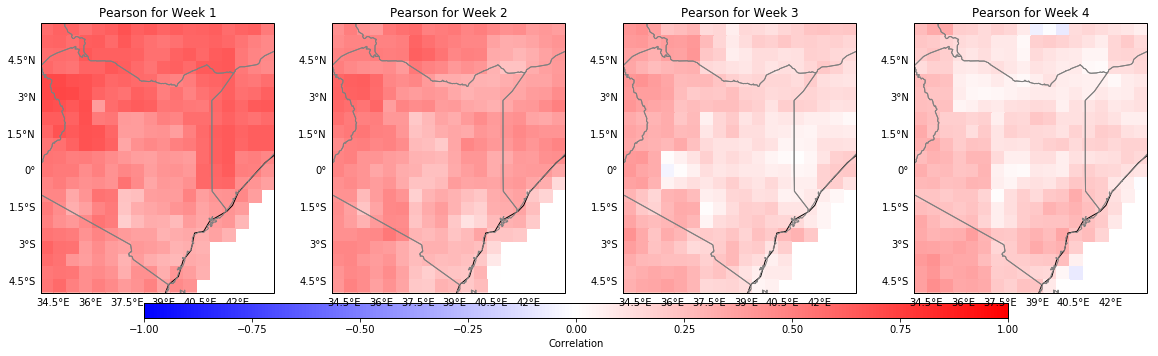

----------------------------------------------



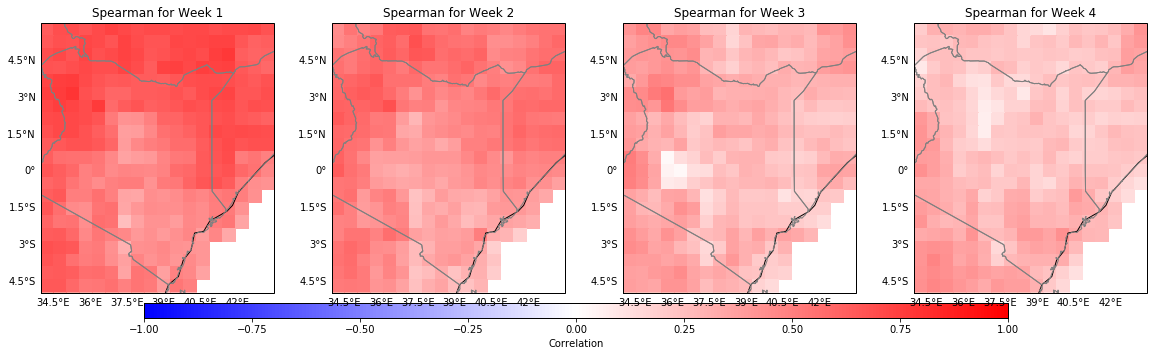

----------------------------------------------



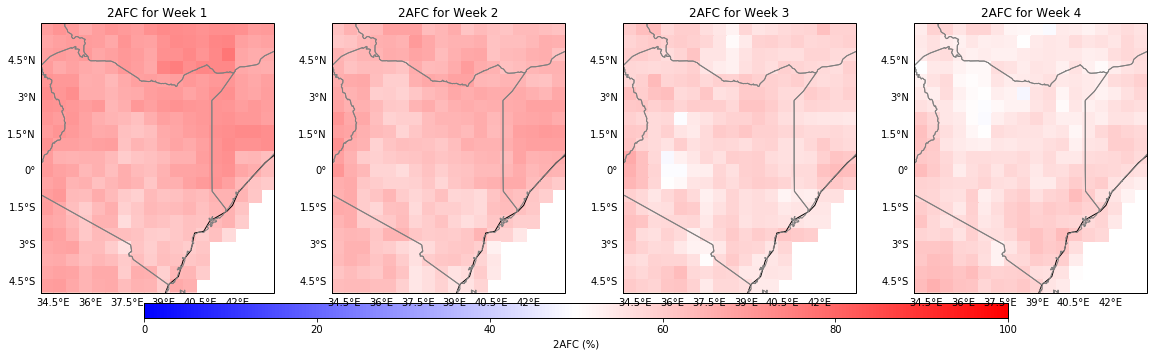

----------------------------------------------



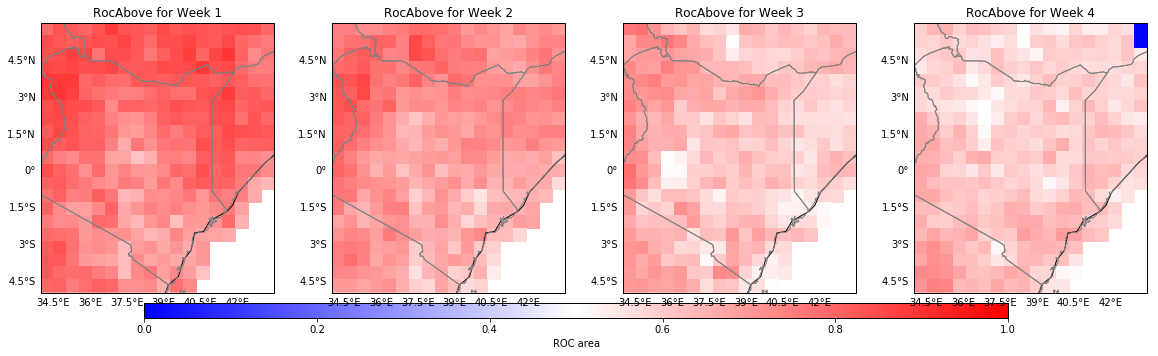

----------------------------------------------



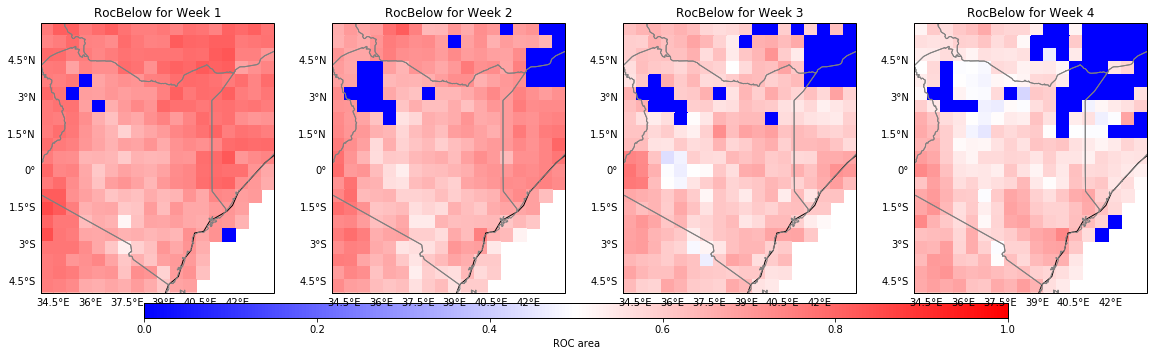

----------------------------------------------



In [9]:
print("New folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 10})
for ime in ('Pearson','Spearman','2AFC','RocAbove','RocBelow'):
    pltmap(ime,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk)   
    plt.show()
    print('----------------------------------------------')
    print('')

In [10]:
print("Folder:")
%cd $workdir/output

#Desired scores: 
score=('Spearman','2AFC','RocAbove','RocBelow')
#Coordinates of the box:
# Kenya:
lon1=35 #lon of upper left point of geographical sub-domain
lat1=4  #lat of upper left point of geographical sub-domain
lon2=40.5 #lon of lower right point of geographical sub-domain
lat2=-2.5  #lat of lower right point of geographical sub-domain

# ASEAN:
# lon1=100 #lon of upper left point of geographical sub-domain
# lat1=6  #lat of upper left point of geographical sub-domain
# lon2=105 #lon of lower right point of geographical sub-domain
# lat2=0  #lat of lower right point of geographical sub-domain
# Skill scores loop
df=skilltab(score,wknam,lon1,lat1,lat2,lon2,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk)
df

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/KenyaOND/output


,Spearman,max(Spearman),min(Spearman),2AFC,max(2AFC),min(2AFC),RocAbove,max(RocAbove),min(RocAbove),RocBelow,max(RocBelow),min(RocBelow)
Week 1,0.55,0.79,0.25,65.419998,71.930000,56.709999,0.76,0.89,0.62,0.67,0.81,0.0
Week 2,0.44,0.69,0.24,61.939999,68.099998,56.639999,0.70,0.86,0.55,0.59,0.72,0.0
Week 3,0.29,0.56,0.03,57.520000,63.560001,48.720001,0.63,0.75,0.49,0.55,0.72,0.0
Week 4,0.23,0.37,0.07,55.450001,60.720001,48.369999,0.59,0.67,0.50,0.52,0.68,0.0


## Forecast maps

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/KenyaOND/output
----------------------------------------------



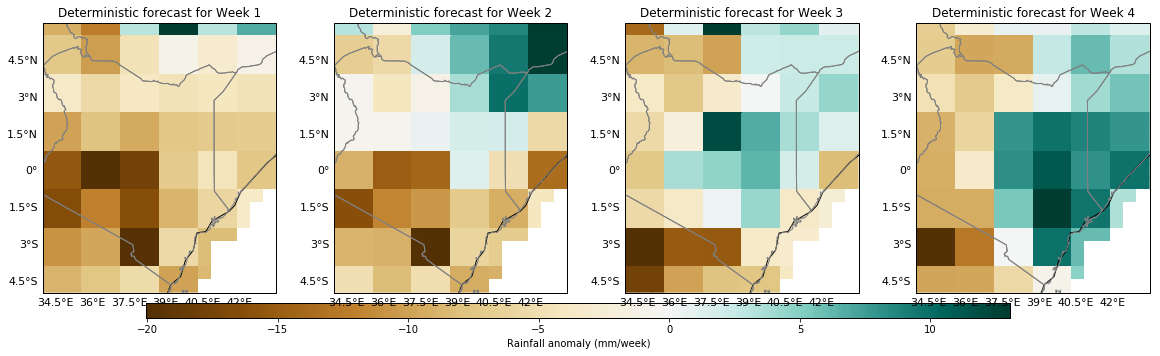

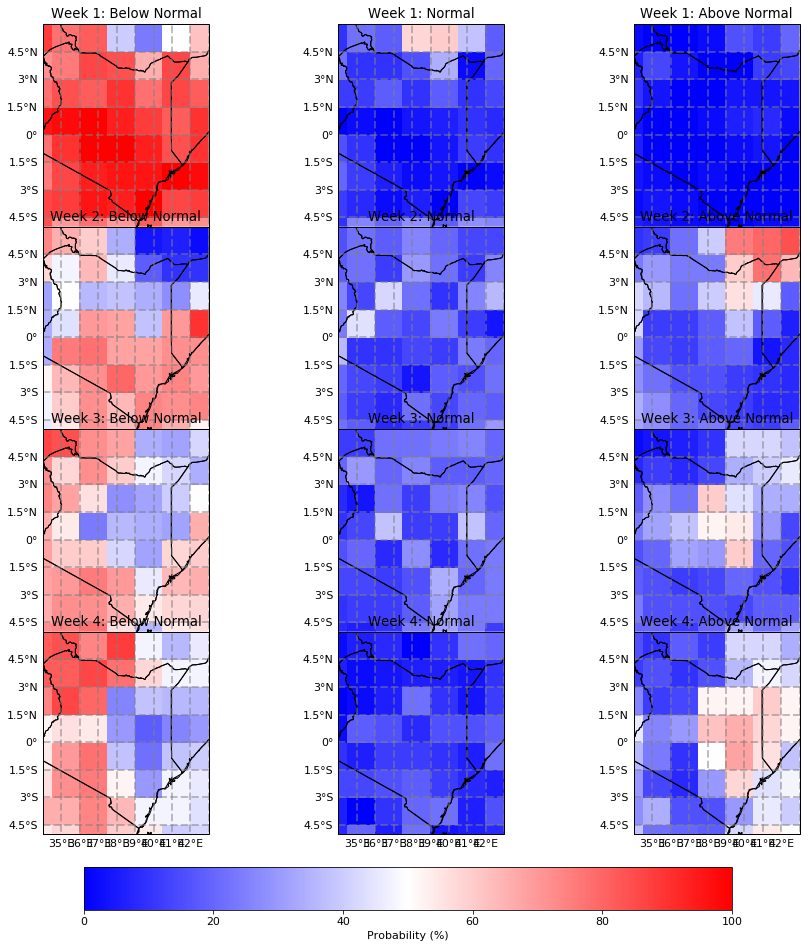

In [11]:
print("Folder:")
%cd $workdir/output

plt.rcParams.update({'font.size': 10})
pltmap(mpref+'FCST_V',wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk)
print('----------------------------------------------')
print('')
plt.rcParams.update({'font.size': 11})
pltmapProb(wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk)
plt.savefig("ProbFcst.pdf", dpi=300)

### Flexible Forecasts

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/KenyaOND/output


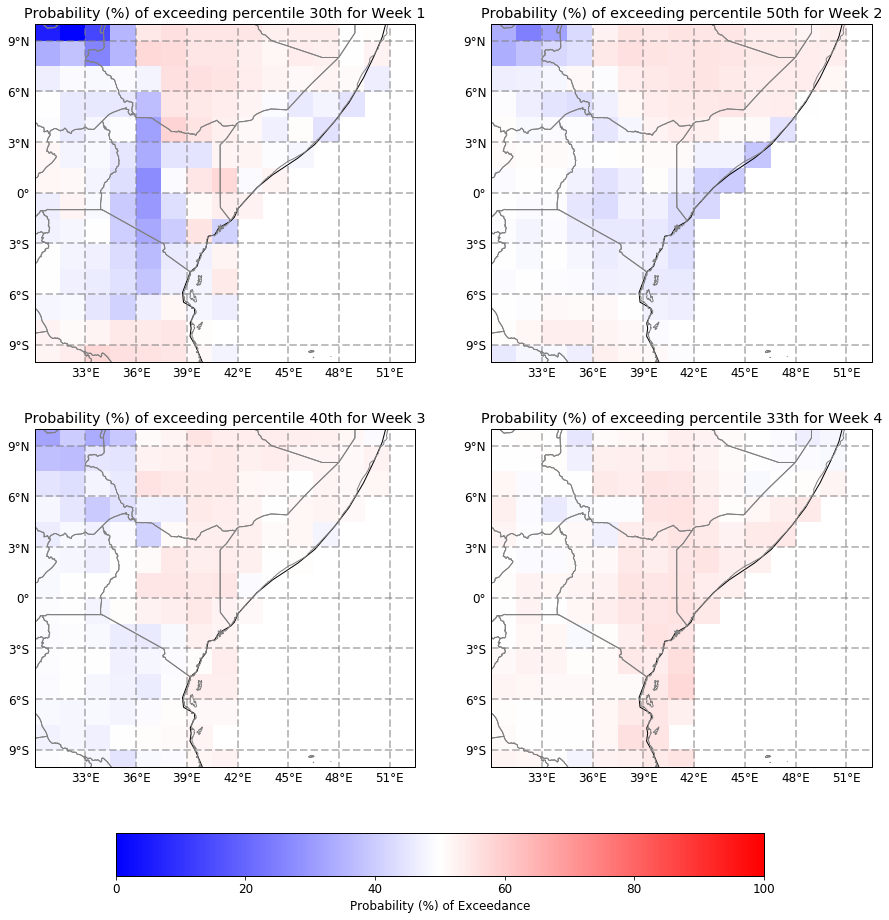

In [12]:
#threshold for the flexible format map (in mm/week -- remember: fcsts are in ANOMALIES!):
flexformat_threshold = [0.3,0.5,0.4,0.33] #array (we need one threshold per week to forecast)
ffthres_ispctl=True  #If True, flex format threshold is a percentile: 0.001 - 0.999

print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
if mpref=='noMOS' and fprefix=='PRCP':
    pltmapff(flexformat_threshold,ffthres_ispctl,ntrain,wlo1,elo1,sla1,nla1,fprefix,mpref,training_season,mon,fday,nwk)
else:
    pltmapff(flexformat_threshold,ffthres_ispctl,ntrain,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk)
plt.savefig("ProbFcst_Flex.pdf", dpi=300)

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/KenyaOND/output


<Figure size 1080x1080 with 0 Axes>

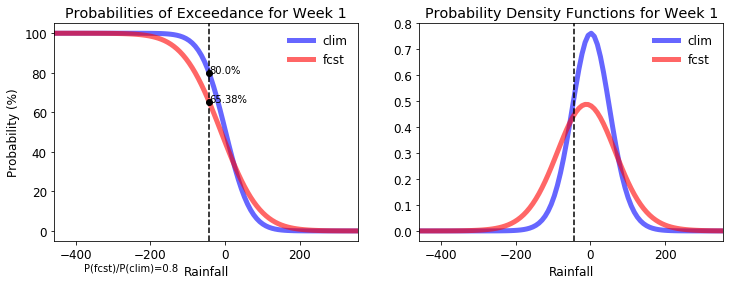

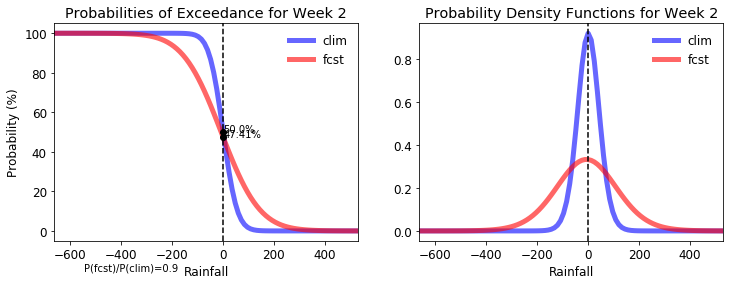

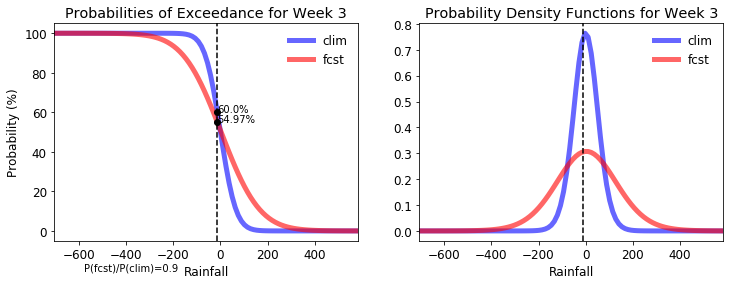

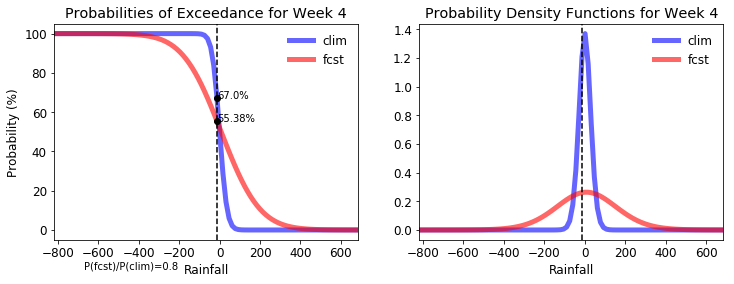

In [13]:
#threshold for the flexible format map (in mm/week -- remember: fcsts are in ANOMALIES!):
flexformat_threshold = [0.2,0.5,0.4,0.33] #array (we need one threshold per week to forecast)
ffthres_ispctl=True  #If True, flex format threshold is a percentile: 0.001 - 0.999
#Location coordinates:
#lon=100.
#lat=0.
lon=40.
lat=0.
 
print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltprobff(flexformat_threshold,ffthres_ispctl,ntrain,lon,lat,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk)
plt.savefig("ProbExceed.pdf", dpi=300)